# DOPP 2020W Exercise 3
## Group 10

**Question:**

How has the use of nuclear energy evolved over time? How well does the use of nuclear energy correlate with changes in carbon emissions? Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

**Members:**

* Josef Glas 08606876
* Felix Korbelius 01526132
* Frank Ebel 01429282
* Johannes Schabbauer 11776224

**Work method:**

Each person wrote python scripts for their respective tasks. These scripts were merged in this notebook by Frank and modified if necessary. The repostory is available on [GitHub](https://github.com/e8606876/dopp10).
<br> <span style="color:red">todo_frank Make repository public.</span>

## Loading necessary modules

Since we have widgets, this option must be run first:\
`jupyter nbextension enable --py widgetsnbextension --sys-prefix`

In [1]:
# file manipulation
import requests
import re
import os

# working with data
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# country manipulation
import country_converter
import pycountry
import logging

# widgets
import ipywidgets as widgets

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import plotly.express as px
import geopandas
import mplcursors

In [2]:
# initialize CountryConverter as cc and disable warnings
country_converter.logging.getLogger().setLevel(logging.CRITICAL)
cc = country_converter.CountryConverter()

## Finding appropiate datasets.

We decided that each person should focus on different categories. Each dataset should be sorted by the combination of country and year. To be consistent with country names we decided to use ISO 3166 alpha 3 country codes.  They categories were divided the following way:


* Josef: energy consumption and production data
* Felix: ecological data (CO$_2$-emission, pollution, ...)
* Frank: economical data (GDP, income, growth, ...)
* Johannes: (operating reactors, government, , accidents, climate agreements ...)

**Used datasets**

All used datasets are in the folder `./data`.

* __[U.S. Energy Information Administration](https://www.eia.gov/international/data/world)__\
`USEIA/`
* __[Data on CO2 and Greenhouse Gas Emissions by Our World in Data](https://github.com/owid/co2-data)__\
`owid-co2-data.csv`
* __[GDP (current USD)](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)__\
`API_NY.GDP.MKTP.CD_DS2_en_csv_v2_1740389/`
* __[GDP growth (annual \%)](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG)__\
`API_NY.GDP.MKTP.CD_DS2_en_csv_v2_1740389/`
* __[GDP per capita (current USD)](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)__\
`API_NY.GDP.PCAP.CD_DS2_en_csv_v2_1740213`
* __[GDP per capita growth (annual \%)](https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG)__\
`API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_1740284/`
* __[Adjusted net national income per capita (current USD)](https://data.worldbank.org/indicator/NY.ADJ.NNTY.PC.CD)__\
`API_NY.ADJ.NNTY.PC.CD_DS2_en_csv_v2_1745486`
* __[Adjusted net national income per capita (annual \% growth)](https://data.worldbank.org/indicator/NY.ADJ.NNTY.PC.KD.ZG)__ \
`API_NY.ADJ.NNTY.PC.KD.ZG_DS2_en_csv_v2_1745488/`
* __[Power Reactor Information System](https://pris.iaea.org/PRIS/CountryStatistics/CountryStatisticsLandingPage.aspx)__\
`reactor_numbers_PRIS_IAEA.csv`
* __[Nuclear Wareheads per country](https://data.world/datagraver/nuclear-warheads-per-country)__\
`nuclear_warheads_1945_2016.csv`
* __[Gross domestic expenditure on R&D (GERD), GERD as a percentage of GDP](http://data.uis.unesco.org/Index.aspx?DataSetCode=SCN_DS#)__\
`SCN_DS_16122020083400698.csv`
* __[Nuclear Power Accidents (Deaths and Costs)](https://data.world/rebeccaclay/nuclear-power-accidents)__\
`C_id_35_NuclearPowerAccidents2016.csv`
* __[The Global State of Democracy Indices](https://www.idea.int/gsod-indices/dataset-resources)__\
`gsodi_pv_4.csv`

**Dataset loading by Josef**

In [ ]:
def load_useia_data():
    data = pd.DataFrame()

    ### CONSUMPTION
    target = './data/USEIA/USEIA_CONSUMPTION_1980-2018.csv'

    consumption = pd.read_csv(target, sep=",", decimal=".", header=0, skiprows=1, na_values='--')

    # rename columns
    consumption = consumption.rename(columns={'Unnamed: 1': 'text'})
    consumption.insert(loc=0, column='country', value=0)
    consumption.insert(loc=0, column='check', value='X')

    consumption['country'] = consumption['API'].str[-10:-7]
    #consumption = map_historic_countries(consumption)
    consumption['check'] = cc.convert(names=consumption['country'].to_list(), to='ISO3')

    consumption = consumption.sort_values(by=['country'])

    # data cleaning

    # remove rows where country code check failed
    raw = consumption[consumption['check'] != 'not found']

    raw = raw.reset_index(drop=True)

    consumption = pd.DataFrame(columns=['year', 'country', 'cons_btu', 'coal_cons_btu', 'gas_cons_btu', \
                                        'oil_cons_btu', 'nuclear_cons_btu', 'renewables_cons_btu'])

    countries = pd.DataFrame(raw['country'])
    countries.sort_values(by=['country'])
    countries.drop_duplicates(inplace=True)
    countries = countries.reset_index(drop=True)

    counter = 0
    for idx1, c in countries.iterrows():

        temp = raw[raw['country'] == c.iloc[0]]

        j = 4
        for i in range(1980, 2019):

            v_cons = 0
            v_coal = 0
            v_gas = 0
            v_oil = 0
            v_nuclear = 0
            v_renewables = 0

            new_row = {'year': i, 'country': c.iloc[0]}
            for idx2, row in temp.iterrows():

                text = row.iloc[3]

                if text.find("Consumption") != -1:
                    v_cons = row.iloc[j]
                elif text.find("Coal") != -1:
                    v_coal = row.iloc[j]
                elif text.find("Natural gas") != -1:
                    v_gas = row.iloc[j]
                elif text.find("Petroleum") != -1:
                    v_oil = row.iloc[j]
                elif text.find("Nuclear (") != -1:
                    v_nuclear = row.iloc[j]
                elif text.find("Renewables and other") != -1:
                    v_renewables = row.iloc[j]

            new_row['cons_btu'] = v_cons
            new_row['coal_cons_btu'] = v_coal
            new_row['gas_cons_btu'] = v_gas
            new_row['oil_cons_btu'] = v_oil
            new_row['nuclear_cons_btu'] = v_nuclear
            new_row['renewables_cons_btu'] = v_renewables

            consumption.loc[counter] = new_row
            counter += 1
            j += 1

    ### PRODUCTION
    target = './data/USEIA/USEIA_PRODUCTION_1980-2018.csv'

    production = pd.read_csv(target, sep=",", decimal=".", header=0, skiprows=1, na_values='--')

    # rename columns
    production = production.rename(columns={'Unnamed: 1': 'text'})
    production.insert(loc=0, column='country', value=0)
    production.insert(loc=0, column='check', value='X')

    production['country'] = production['API'].str[-10:-7]
    #production = map_historic_countries(production)
    production['check'] = cc.convert(names=production['country'].to_list(), to='ISO3')

    production.sort_values('country')

    # data cleaning

    # remove rows where country code check failed
    raw = production[production['check'] != 'not found']

    raw = raw.reset_index(drop=True)

    production = pd.DataFrame(columns=['year', 'country', 'prod_btu', 'coal_prod_btu', 'gas_prod_btu', \
                                       'oil_prod_btu', 'nuclear_prod_btu', 'renewables_prod_btu'])

    countries = pd.DataFrame(raw['country'])
    countries.sort_values(by=['country'])
    countries.drop_duplicates(inplace=True)
    countries = countries.reset_index(drop=True)

    counter = 0
    for idx3, c in countries.iterrows():

        temp = raw[raw['country'] == c.iloc[0]]

        j = 4
        for i in range(1980, 2019):

            v_prod = 0
            v_coal = 0
            v_gas = 0
            v_oil = 0
            v_nuclear = 0
            v_renewables = 0

            new_row = {'year': i, 'country': c.iloc[0]}
            for idx4, row in temp.iterrows():

                text = row.iloc[3]

                if text.find("Production") != -1:
                    v_prod = row.iloc[j]
                elif text.find("Coal") != -1:
                    v_coal = row.iloc[j]
                elif text.find("Natural gas") != -1:
                    v_gas = row.iloc[j]
                elif text.find("Petroleum") != -1:
                    v_oil = row.iloc[j]
                elif text.find("Nuclear (") != -1:
                    v_nuclear = row.iloc[j]
                elif text.find("Renewables and other") != -1:
                    v_renewables = row.iloc[j]

            new_row['prod_btu'] = v_prod
            new_row['coal_prod_btu'] = v_coal
            new_row['gas_prod_btu'] = v_gas
            new_row['oil_prod_btu'] = v_oil
            new_row['nuclear_prod_btu'] = v_nuclear
            new_row['renewables_prod_btu'] = v_renewables

            production.loc[counter] = new_row
            counter += 1
            j += 1

    data = pd.merge(consumption, production, how="outer", on=['year', 'country'])

    data['year'] = data['year'].astype('int64')
    data['nuclear_prod_btu'] = data['nuclear_prod_btu'].astype('float64')

    return data

**Dataset loading by Felix**

In [ ]:
def load_emission_data():
    """ 
    Load all emission data files and combine them into a single Pandas DataFrame.
    Common data structure: 0-year, 1-country code, 2+-features.
    Check for correct typing.

    return:
    emission_data: data frame containing different emission data per country per year.
    """

    path = './data/owid-co2-data.csv'
    df_emission_data = pd.read_csv(path, sep=',')

    cols = ['year', 'iso_code']
    # Rearrange columns, so that year and country-code (iso-code) are the first two columns.
    new_cols = cols + df_emission_data.columns.drop(cols).tolist()
    # Drop country column.
    df_emission_data = df_emission_data[new_cols].drop(['country'], axis=1)
    # Rename iso_code to country and convert to string.
    df_emission_data[['iso_code']] = df_emission_data[['iso_code']].astype('string')
    df_emission_data = df_emission_data.rename(columns={'iso_code': 'country'})
    return df_emission_data


def resize_emission(df):
    """ Index dataframe and eliminate non-country specific data.

    Attention: When handling NaN values look at the values of a specific column, if there exists a NaN value
    above/below a 0 entry, it is highly possible that NaN are truly missing values.

    Time-range: 1980-2018

    return:
    trimmed down and somewhat ordered emission_data."""
    data_emission_i = df.copy()
    # Only keep countries (check len(country_code) == 3) - raw data contains continental data, etc. with a blank
    # country code (i.e. length 0).
    data_emission_i = data_emission_i[data_emission_i['country'].str.len() == 3]
    # Set index on country_code and year (group by country_code).
    # data_emission_i = data_emission_i.set_index(['country_code', 'year'])
    # Keep most interesting columns:
    data_emission_i = data_emission_i.drop(data_emission_i.iloc[:, -5:-2], axis=1)
    data_emission_i = data_emission_i.drop(data_emission_i.iloc[:, 16:26], axis=1)  # delete cement,... produc. emission
    data_emission_i = data_emission_i.drop(['gdp', 'trade_co2', 'trade_co2_share'], axis=1)
    return data_emission_i

**Dataset loading by Frank**

In [ ]:
def load_economical_data():
    """Load economical data into dataframe and return it.

    Common data structure:
    0: year
    1: country code
    3..: features"""

    def get_df(filepath):
        df = pd.read_csv(filepath, sep=',', skip_blank_lines=True, header=2)
        df.drop(columns_drop, axis=1, inplace=True)
        df.rename(columns={'Country Code': 'country'}, inplace=True)
        return df

    columns_drop = ['Country Name', 'Indicator Name',  'Indicator Code', 'Unnamed: 65']  # columns to drop
    dfs = []  # List of all dataframes.

    # load dataframe of GDP
    df_GDP = get_df('./data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_1740389/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_1740389.csv')
    # melt and order to get in right format
    df_GDP = df_GDP.melt(id_vars=['country'], var_name='year', value_name='GDP')
    df_GDP['year'] = df_GDP['year'].astype('int64')
    dfs.append(df_GDP)

    # load dataframe of GDP growth
    df_GDP_growth = get_df('./data/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_1836177/'
                           'API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_1836177.csv')
    # melt and order to get in right format
    df_GDP_growth = df_GDP_growth.melt(id_vars=['country'], var_name='year', value_name='GDP growth')
    df_GDP_growth['year'] = df_GDP_growth['year'].astype('int64')
    dfs.append(df_GDP_growth)

    # load dataframe of GDP per capita
    df_GDP_per_capita = get_df('./data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_1740213/'
                               'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_1740213.csv')
    # melt and order to get in right format
    df_GDP_per_capita = df_GDP_per_capita.melt(id_vars=['country'], var_name='year', value_name='GDP per capita')
    df_GDP_per_capita['year'] = df_GDP_per_capita['year'].astype('int64')
    dfs.append(df_GDP_per_capita)

    # load dataframe of GDP per capita growth
    df_GDP_per_capita_growth = get_df('./data/API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_1740284/'
                                      'API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_1740284.csv')
    # melt and order to get in right format
    df_GDP_per_capita_growth = df_GDP_per_capita_growth.melt(id_vars=['country'], var_name='year',
                                                             value_name='GDP per capita growth')
    df_GDP_per_capita_growth['year'] = df_GDP_per_capita_growth['year'].astype('int64')
    dfs.append(df_GDP_per_capita_growth)

    # load dataframe of income per capita
    df_income_per_capita = get_df('./data/API_NY.ADJ.NNTY.PC.CD_DS2_en_csv_v2_1745486/'
                                  'API_NY.ADJ.NNTY.PC.CD_DS2_en_csv_v2_1745486.csv')
    # melt and order to get in right format
    df_income_per_capita = df_income_per_capita.melt(id_vars=['country'], var_name='year',
                                                     value_name='income per capita')
    df_income_per_capita['year'] = df_income_per_capita['year'].astype('int64')
    dfs.append(df_income_per_capita)

    # load dataframe of income per capita growth
    df_income_per_capita_growth = get_df('./data/API_NY.ADJ.NNTY.PC.KD.ZG_DS2_en_csv_v2_1745488/'
                                         'API_NY.ADJ.NNTY.PC.KD.ZG_DS2_en_csv_v2_1745488.csv')
    # melt and order to get in right format
    df_income_per_capita_growth = df_income_per_capita_growth.melt(id_vars=['country'], var_name='year',
                                                                   value_name='income per capita growth')
    df_income_per_capita_growth['year'] = df_income_per_capita_growth['year'].astype('int64')
    dfs.append(df_income_per_capita_growth)

    # merge and sort all dataframes
    result = dfs[0]
    for df in dfs[1:]:
        result = result.merge(df, how='outer', on=['country', 'year'])
    result.sort_values(['country', 'year'], inplace=True)
    result.reset_index(inplace=True, drop=True)

    # Since there are some aggregated values (e. g. WLD for world) remove all rows which don't have a valid
    # ISO 3166 Alpha-3 code.
    alpha_3_list = [country.alpha_3 for country in list(pycountry.countries)]  # all valid codes
    valid_entry = result['country'].isin(alpha_3_list)  # boolean series if each row is valid or not
    result = result.loc[valid_entry]
    # invalid = set(result.loc[~valid_entry]['country'].tolist())
    # print('invalid code\n', invalid)

    return result

**Dataset loading by Johannes**

In [ ]:
# initialize CountryConverter as cc and disable warnings
country_converter.logging.getLogger().setLevel(logging.CRITICAL)
cc = country_converter.CountryConverter()
# dictionary for country replacements (that cannot be read by country_converter)
# using current ones for outdated names, e.g. 'USSR' --> 'Russia'
_dict_country_repl = {'UK':'United Kingdom', 'USSR':'Russia', 'Soviet Union':'Russia', 'East Germany':'Germany',
                      'Illinois':'US', 'Tawian':'Taiwan', 'Yugoslavia':'Serbia', 'Scotland':'United Kingdom'}

###################################################################################################
def load_political_data():
    # read data from diffenernt datasets in the category 'political'
        
    # nuclear warheads
    # read file and exclude last (empty) line
    warheads = pd.read_csv('./data/nuclear_warheads_1945_2016.csv', 
                           sep=';',thousands='.', decimal=',').iloc[:-1]
    warheads['Year'] = warheads['Year'].astype('int')
    warheads = warheads.set_index('Year')
    # extent years to 2020 and interpolate
    warheads = warheads.reindex(np.arange(1945,2021,dtype='int'), method='ffill')
    # transform datafame from 2D to MultiIndex
    warheads = warheads.stack()
    warheads = warheads.reset_index()
    # set column names and convert country names to ISO3
    warheads.columns = ['year', 'country', 'nuclear_warheads']
    warheads['country'] = cc.convert(warheads['country'].to_list(), to='ISO3')
    warheads = warheads.set_index(['year', 'country'])

    
    # research expenditure
    research = pd.read_csv('./data/SCN_DS_16122020083400698.csv')
    # choose only lines with relatilve expenditure (for all reaseach categories)
    research = research.loc[research['Indicator']=="GERD as a percentage of GDP"]
    # chose relevant columns and rename them
    research = research[['Time','Country', 'Value']]
    research.columns = ['year', 'country', 'research_%GDP']
    # convert to ISO3 and exclude regions (cannot be converted to countrycode)
    research['country'] = research['country'].replace({'Oceania (Australia/New Zealand)':'not found'})
    research['country'] =  cc.convert(research['country'].to_list(), to='ISO3', not_found='not found')
    research = research[research['country'] != 'not found']
    research = research.set_index(['year', 'country'])

    
    # accidents of nuclear power plants
    accidents = pd.read_csv('./data/C_id_35_NuclearPowerAccidents2016.csv')
    accidents = accidents[['Date', 'Location', 'Cost (millions 2013US$)', 'Fatalities']]
    accidents.columns = ['year', 'country', 'accident_cost_MioUSD2013', 'accident_deaths']
    # use only year from Date column
    accidents['year'] = accidents['year'].str.slice(start=-4).astype('int')
    # use last part of Location (usually the country)
    accidents['country'] = accidents['country'].str.split(',').str[-1].str.lstrip(' ')
    # do some corrections (e.g. old country names or missing ones)
    accidents['country'] = accidents['country'].replace(_dict_country_repl)
    # conversion to ISO3
    accidents['country'] = cc.convert(accidents['country'].to_list(), to='ISO3')
    accidents = accidents.set_index(['year', 'country'])
    # sum values, if there was more than one accident per year and country
    accidents = accidents.sum(level=['year','country'])
    
    # democarcy indicators
    democracy = pd.read_csv('./data/gsodi_pv_4.csv', low_memory=False)
    # choose five main categories
    democracy = democracy[['ID_year','ID_country_name','C_A1','C_A2','C_A3','C_A4','C_SD51']]
    democracy.columns = ['year', 'country', 'representative_government', 'fundamental_rights', 
                         'checks_on_gouvernment', 'impartial_administration', 'civil_society_participation']
    # avoid that 'Southern Africa' is converted to 'ZAF' and count 'East Germany' as 'Germany' 
    democracy['country'] = democracy['country'].replace(
            {'Southern Africa':' ','German Democratic Republic':'Germany'})
    democracy['country'] = cc.convert(democracy['country'].to_list(), to='ISO3')
    # exclude regions (and east germany)
    democracy = democracy[democracy['country'] != 'not found']
    democracy = democracy.set_index(['year', 'country'])
    # use mean value for duplicate values (EAST and WEST GERMANY)
    democracy = democracy.mean(level=['year','country'])

    # get number of reactors from seperate function
    reactors = load_reactor_numbers()
    
    # merging and fill some of the missing values
    merge = pd.concat(
            [reactors,warheads,accidents,research,democracy],
            axis=1, join='outer')
    
    merge = merge.sort_index(level=['country'])
    
    return merge

###################################################################################################
def load_reactor_numbers():
    # loading number of operational nuclear power plants from IAEA-PRIS database (public version)
    
    # if data was already loaded from webpages, read directly from saved csv file
    if os.path.isfile('./data/reactor_numbers_PRIS_IAEA.csv'):
        reactors = pd.read_csv('./data/reactor_numbers_PRIS_IAEA.csv', index_col=[0,1])
        return reactors
    
    # create containers for reactor data per country
    startup_dict=dict()
    shutdown_dict=dict()

    # fetch table for reactors from public webpage
    url = 'https://pris.iaea.org/PRIS/CountryStatistics/ReactorDetails.aspx?current='
    for num in range(1000): # manual maximal id of reactor
        page = requests.get(url+str(num))
        if page.status_code < 400: # exclude non-existing IDs
            # find country (ISO2) in html and load tables from page
            country = re.findall('[\d\D]*color="DarkGray"', str(page.content))[0][-26:-24]
            country = cc.convert(country, src='ISO2', to='ISO3')
            # create dict entries for new countries
            if country not in startup_dict.keys():
                startup_dict[country] = np.empty(shape=0, dtype='int')
                shutdown_dict[country] = np.empty(shape=0, dtype='int')
            page_df = pd.read_html(page.content)
            if len(page_df) < 3: # exclude reactor if never started
                continue
            # get year of startup
            if page_df[0].iloc[6,1]=='Commercial Operation Date':
                # if 'Commercial Operation Date' is not given (NaN), use 'First Grid Connection'
                if type(page_df[0].iloc[7,1]) != 'str':
                        startup_dict[country] = np.append(startup_dict[country], int(page_df[0].iloc[7,0][-4:]))
                else:
                    startup_dict[country] = np.append(startup_dict[country], int(page_df[0].iloc[7,1][-4:]))
            # get year of reactor shutdown (if given)
            if page_df[0].iloc[8,0]=='Permanent Shutdown Date':
                shutdown_dict[country] = np.append(shutdown_dict[country], int(page_df[0].iloc[9,0][-4:]))

    # calculate operating reactors from startup and shutdown dates
    # of each reactor (from dicts) for each country per year
    reactors = pd.DataFrame()
    for ISO in startup_dict.keys():
        if len(startup_dict[ISO])==0:
            continue
        reactors_country = pd.DataFrame()
        reactors_country['year'] = np.arange(startup_dict[ISO].min(),2021)
        reactors_country['country'] = np.full(shape=reactors_country.shape[0], fill_value=ISO)
        reactors_country['built_reactors'] = np.fromiter(
                (startup_dict[ISO][startup_dict[ISO] <= year].size for year in reactors_country['year'] )
                ,dtype='int')
        reactors_country['shutdown_reactors'] = np.fromiter(
                (shutdown_dict[ISO][shutdown_dict[ISO] <= year].size for year in reactors_country['year'] )
                ,dtype='int')
        reactors_country['operating_reactors'] = reactors_country['built_reactors'] - reactors_country['shutdown_reactors']
        reactors = pd.concat([reactors, reactors_country],axis=0)
    reactors = reactors.set_index(['year', 'country'])
    # save DataFrame to csv-file, to fetch data not everytime
    reactors.to_csv('./data/reactor_numbers_PRIS_IAEA.csv')
    return reactors

### Merging datasets

This was worked on by Frank. The function <span style="color:blue">clean_data_after_merge()</span> was written by Johannes. Since running the cell below takes a lot of time, the merged and cleaned dataframe was written to `./data/data_merged/data.csv`. For exploring the data, loading the csv was much faster than running the code in the next cell each time.

In [ ]:
def clean_data_after_merge(df):
    """Fill some missing data in merged dataframe."""

    for column in ['built_reactors', 'shutdown_reactors', 'operating_reactors', 'nuclear_warheads']:
        df[column].fillna(value=0, inplace=True)
    for column in ['accident_cost_MioUSD2013', 'accident_deaths']:
        df[column].fillna(value=0, inplace=True)

        
df_energy = load_useia_data()
df_emission = resize_emission(load_emission_data())
df_economy = load_economical_data()
df_politics = load_political_data()
df_politics.reset_index(drop=False, inplace=True)

# merge all dataframes:
dataframe = df_energy
for df in [df_emission, df_economy, df_politics]:
    dataframe = dataframe.merge(df, how='left', on=['year', 'country'])

# clean up some values
clean_data_after_merge(dataframe)

# export to csv
export = False
if export:
    dataframe.to_csv('../data/data_merged/data.csv', index=False)

## Observation and Comments about used datasets:

This part was written by all members.

page 5 of exercise3.pdf

conversion quad btu to EJ
how to format this part? Everyone their own thoughts? All together?

For some information ('built_reactors', 'shutdown_reactors', 'operating_reactors', 'nuclear_recators', 'accident_cost_MioUSD2013', 'accident_deaths') we decided to fill the missing values with the number 0. It was deemed an appropiate solution since there are not a lot of accidents with nuclear power plants (obvious ones like Chernobyl and Fukushima were in the data). 

suggestion: country conversion (USSR), Felix GHG vs CO$_2$ only, Johannes fillna(0) for missing values

Individual observations:

* Josef
* Frank \
    Since it was decided beforehand what each person had to search, it was much easier for me to narrow down what to look for. I found data in .csv and .xslx formats. Of these I thought that .csv formats are easier to work in python with. Some web ruslts only offer datasets behind a paywall, which could not be used for this exercise.
* Felix
* Johannes

## First Visualization of data

The code for the cell below was written by Josef. The code for the dropdown widget was added by Frank.

In [4]:
def load_data_for_plot():

    desc_file = './data/data_merged/description.csv'
    data_file = './data/data_merged/data.csv'

    desc = pd.read_csv(desc_file, sep=",", header=None)
    desc.set_index(0, inplace=True)
    data = pd.read_csv(data_file, sep=",", decimal=".")



    return data, desc


def show_map(df, desc, feature, scope):
    # print(df)
    # print(desc)

    minimum = df[feature].min()
    maximum = df[feature].max()

    fig = px.choropleth(data_frame=df,
                        locations="country",
                        color=feature,  # value in feature column determines color
                        hover_name="country",
                        scope=scope,
                        color_continuous_scale='Reds',  # color scale
                        range_color=(minimum, maximum),
                        animation_frame="year",
                        title='Development of feature ' + feature + ': ' + desc)
    # do not show antarctica in world map
    if scope == 'world':
        fig.layout.geo.lataxis.range = [-55, 90]
    fig.show()


def wrapper(feature):
    description = desc.loc[feature][1]
    # change scope if necessary (world, usa, europe, asia, africa, north america, ...)
    show_map(df, description, feature, 'world')


df, desc = load_data_for_plot()

options = df.columns.drop(['year', 'country'])
widgets.interact(wrapper, feature=options);

interactive(children=(Dropdown(description='feature', options=('cons_btu', 'coal_cons_btu', 'gas_cons_btu', 'o…

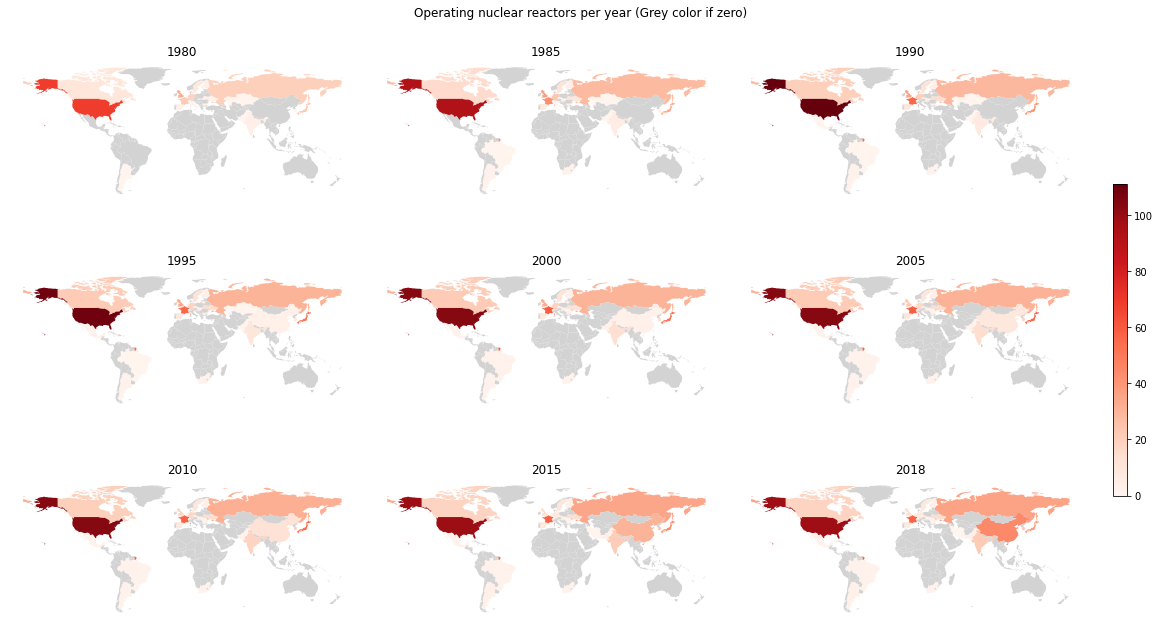

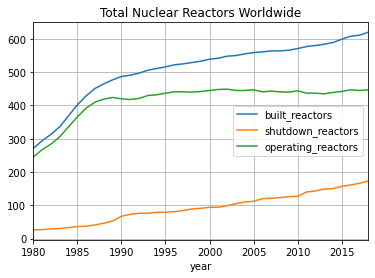

In [7]:
def plot_operating_reactors():
    """
    Show how the number of operating reactors has evolved over time in different countries and worldwide.
    """
    # get GeoPandas data for world map
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    # drop antarctica
    world = world.drop(world.index[159])
    # in provided dataframe, some ISO codes (France) are wrong, so let's use the converter
    world['iso_a3'] = cc.convert(world['name'].to_list(), to='ISO3')

    # get data of nuclear reactors
    data = pd.read_csv('./data/data_merged/data.csv').set_index(['year', 'country'])
    data = data[['built_reactors', 'shutdown_reactors', 'operating_reactors']]

    # merge with geographical data
    def merge_year(year):
        merge = pd.merge(world, data.loc[year].replace(0, np.nan), left_on='iso_a3', right_on='country', how='left')
        return merge

    # create plots for given years
    years = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2018]
    fig, ax = plt.subplots(math.ceil(len(years)/3), 3, constrained_layout=True,
                           sharex=True, sharey=True,
                           subplot_kw=dict(aspect='equal'), figsize=(16, 9))
    # flatten axes for iteration
    ax = ax.ravel()

    for i, year in enumerate(years):
        merge_year(year).plot(
            column='operating_reactors',
            ax=ax[i],
            missing_kwds={"color": "lightgrey", "label": "No nuclear power plants"},  # missing values in grey
            cmap='Reds',  # scheme of colormap
            vmin=0,
            vmax=data.query("year in @years")['operating_reactors'].max()  # set maximum of legend (would be different for every subplot)
            )
        ax[i].set_title(f'{year}')
        ax[i].axis('off')
    patch_col = ax[0].collections[0]
    fig.colorbar(patch_col, ax=ax, shrink=0.5)
    fig.suptitle('Operating nuclear reactors per year (Grey color if zero)')
    # plt.show()

    # second plot for evolution of total reactors worldwide
    data_sum = data.sum(axis=0, level='year').sort_index()
    data_sum.plot()
    plt.legend(loc='best')
    plt.title('Total Nuclear Reactors Worldwide')
    plt.xlim(data_sum.index.min(), data_sum.index.max())
    plt.grid()
    plt.show()
    
plot_operating_reactors()

## Question 1: How has the use of nuclear energy evolved over time?

The code to answer this question was generated by Josef.

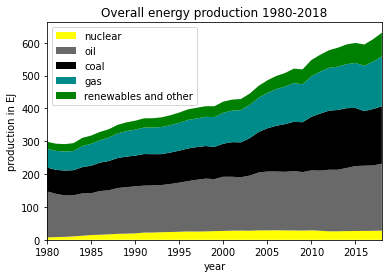

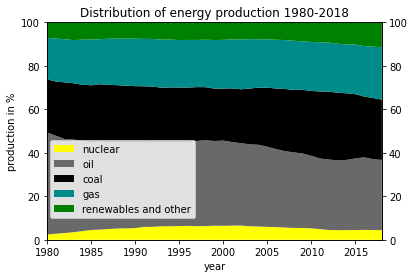

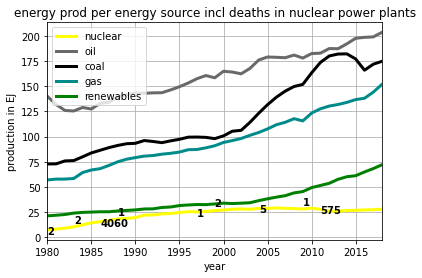

<ipython-input-3-e8eb5559d237>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['change2'] = np.where((df9.op_reactors_1998 == 0), 0, df9.change2)
<ipython-input-3-e8eb5559d237>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['change2'] = np.where((df9.op_reactors_2018 == 0), 0, df9.change2)


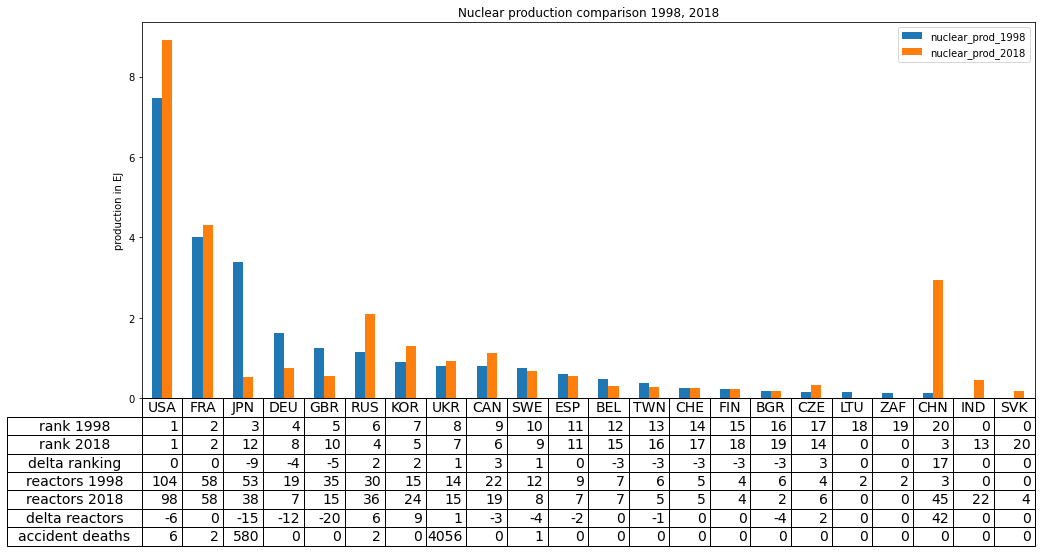

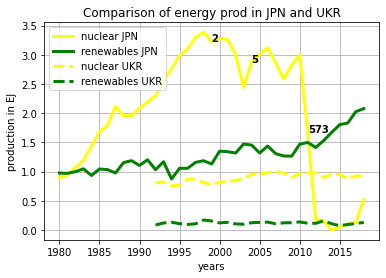

In [3]:
def load_data_q1():
    desc_file = './data/data_merged/description.csv'
    data_file = './data/data_merged/data.csv'

    data = pd.read_csv(data_file, sep=",", decimal=".")

    data = data[['year', 'country',
                 'cons_btu', 'coal_cons_btu', 'gas_cons_btu', 'oil_cons_btu', 'nuclear_cons_btu', 'renewables_cons_btu',
                 'prod_btu', 'coal_prod_btu', 'gas_prod_btu', 'oil_prod_btu', 'nuclear_prod_btu',
                 'renewables_prod_btu', 'accident_deaths', 'operating_reactors']]

    # convert quad btu in EJ (except for first two and last two columns)
    conversion_factor = 1.055
    data.iloc[:,2:-2] = data.iloc[:,2:-2] * conversion_factor
    return data


def show_plot0(df):
    df1 = df[['year', 'oil_prod_btu', 'coal_prod_btu', 'gas_prod_btu', 'nuclear_prod_btu', 'renewables_prod_btu']]

    df1 = df1.groupby(['year']).sum()

    y = [df1["nuclear_prod_btu"], df1["oil_prod_btu"], df1["coal_prod_btu"], df1["gas_prod_btu"],
         df1["renewables_prod_btu"]]

    colors = ['yellow', 'dimgray', 'black', 'darkcyan', 'green']
    labels = ['nuclear', 'oil', 'coal', 'gas', 'renewables and other']

    plt.stackplot(df1.index, y, labels=labels, colors=colors)

    plt.title('Overall energy production 1980-2018')
    plt.xlabel(xlabel='year')
    plt.ylabel(ylabel='production in EJ')
    plt.legend(loc='upper left')
    plt.xlim(df['year'].min(), df['year'].max())

    plt.show()

    return


def show_plot1(df):
    df1 = df[['year', 'oil_prod_btu', 'coal_prod_btu', 'gas_prod_btu', 'nuclear_prod_btu', 'renewables_prod_btu']]

    df1 = df1.groupby(['year']).sum()

    y = [df1["nuclear_prod_btu"], df1["oil_prod_btu"], df1["coal_prod_btu"], df1["gas_prod_btu"],
         df1["renewables_prod_btu"]]

    y0 = (y[0] / (y[0] + y[1] + y[2] + y[3] + y[4]) * 100)
    y1 = (y[1] / (y[0] + y[1] + y[2] + y[3] + y[4]) * 100)
    y2 = (y[2] / (y[0] + y[1] + y[2] + y[3] + y[4]) * 100)
    y3 = (y[3] / (y[0] + y[1] + y[2] + y[3] + y[4]) * 100)
    y4 = (y[4] / (y[0] + y[1] + y[2] + y[3] + y[4]) * 100)

    percent = [y0, y1, y2, y3, y4]

    colors = ['yellow', 'dimgray', 'black', 'darkcyan', 'green']
    labels = ['nuclear', 'oil', 'coal', 'gas', 'renewables and other']

    plt.stackplot(df1.index, percent, labels=labels, colors=colors)

    plt.title('Distribution of energy production 1980-2018')
    plt.xlabel(xlabel='year')
    plt.ylabel(ylabel='production in %')
    plt.legend(loc=(0.01, 0.1))
    plt.xlim(df['year'].min(), df['year'].max())
    plt.ylim((0, 100))
    ax2 = plt.twinx()
    ax2.set_ylim((0, 100))

    plt.show()

    return


def show_plot2(df):
    df1 = df[['year', 'oil_prod_btu', 'coal_prod_btu', 'gas_prod_btu', 'renewables_prod_btu', 'nuclear_prod_btu']]
    df1 = df1.groupby(['year']).sum()
    df1 = df1.rename(columns={'oil_prod_btu': 'oil', 'coal_prod_btu': 'coal', 'gas_prod_btu': 'gas',
                              'renewables_prod_btu': 'renewables', 'nuclear_prod_btu': 'nuclear'})
    df1 = df1.reset_index()

    df2 = df[['year', 'accident_deaths']]
    df2 = df2.groupby(['year']).sum()

    ax = plt.gca()

    df1.plot(kind='line', x='year', y='nuclear', color='yellow', ax=ax, linewidth=3)
    df1.plot(kind='line', x='year', y='oil', color='dimgray', ax=ax, linewidth=3)
    df1.plot(kind='line', x='year', y='coal', color='black', ax=ax, linewidth=3)
    df1.plot(kind='line', x='year', y='gas', color='darkcyan', ax=ax, linewidth=3)
    df1.plot(kind='line', x='year', y='renewables', color='green', ax=ax, linewidth=3)

    plt.title('energy prod per energy source incl deaths in nuclear power plants')
    plt.xlabel(xlabel='year')
    plt.ylabel(ylabel='production in EJ')
    plt.legend(loc='upper left')
    plt.grid()
    plt.xlim(df['year'].min(), df['year'].max())

    shift = -4
    for x, y in zip(df1['year'], df1['nuclear']):
        label = df2.loc[x]
        if label[0] > 0:
            plt.annotate(label[0].astype('int32'), (x, y + shift), fontweight='bold')
            shift = shift * -1

    plt.show()

    return


def show_plot3(df):  # top 10 nuclear energy producers 1980 vs 2018

    df['year'] = df['year'].astype('int32')

    df1 = df.where(df["year"] == 1998)
    df2 = df1.groupby(['country']).sum()
    df2 = df2.sort_values(by=['nuclear_prod_btu'], ascending=False)
    df2 = df2[['nuclear_prod_btu', 'operating_reactors']].head(20)
    df2.rename(columns={'operating_reactors': 'op_reactors_1998', 'nuclear_prod_btu': 'nuclear_prod_1998'},
               inplace=True)
    df2.insert(0, 'rank1998', range(1, 21))

    df3 = df.where(df["year"] == 2018)
    df4 = df3.groupby(['country']).sum()
    df4 = df4.sort_values(by=['nuclear_prod_btu'], ascending=False)
    df4 = df4[['nuclear_prod_btu', 'operating_reactors']].head(20)
    df4.rename(columns={'operating_reactors': 'op_reactors_2018', 'nuclear_prod_btu': 'nuclear_prod_2018'},
               inplace=True)
    df4.insert(0, 'rank2018', range(1, 21))

    df5 = df2.merge(df4, how='outer', on=['country'])
    df5 = df5.fillna(0)
    df5.insert(0, 'movement', (df5['rank1998'] - df5['rank2018']).astype('int32'))

    df5['movement'] = np.where((df5.rank1998 == 0), 0, df5.movement)
    df5['movement'] = np.where((df5.rank2018 == 0), 0, df5.movement)

    df6 = df.groupby(['country']).sum()
    df6 = df6[['accident_deaths']]

    df7 = df5.merge(df6, how='left', on=['country'])

    # print(df7)

    df8 = df7.drop(columns=['accident_deaths', 'op_reactors_1998', 'op_reactors_2018',
                            'movement', 'rank2018', 'rank1998'])

    # figsize
    fig, ax = plt.subplots(figsize=(16, 9))
    
    df8.plot(kind="bar", ax=ax)
    plt.title('Nuclear production comparison 1998, 2018')
    plt.xlabel(xlabel='')
    plt.ylabel(ylabel='production in EJ')
    plt.legend(loc='upper right')

    plt.gca().set_xticks([])

    df9 = df7[['rank1998', 'rank2018', 'movement', 'op_reactors_1998', 'op_reactors_2018', 'accident_deaths']]
    df9.insert(5, 'change2', (df9['op_reactors_2018'] - df9['op_reactors_1998']).astype('int32'))
    df9['change2'] = np.where((df9.op_reactors_1998 == 0), 0, df9.change2)
    df9['change2'] = np.where((df9.op_reactors_2018 == 0), 0, df9.change2)
    df9 = df9.T
    rowlabels = ['rank 1998', 'rank 2018', 'delta ranking', 'reactors 1998', 'reactors 2018', 'delta reactors', 'accident deaths']
    the_table = plt.table(cellText=df9.astype('int').values,
                          rowLabels=rowlabels,
                          colLabels=df9.columns,
                          cellLoc='right', rowLoc='center',
                          loc='bottom')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1,2)

    plt.subplots_adjust(bottom=0.3)

    plt.show()
    return


def show_plot4(df):
    df0 = df[['year', 'renewables_prod_btu', 'nuclear_prod_btu', 'country', 'accident_deaths']]
    df0.index = df0.year

    df1 = df0[df0['country'] == 'JPN']
    df2 = df0[df0['country'] == 'UKR']

    df1 = df1.rename(columns={'renewables_prod_btu': 'renewables JPN', 'nuclear_prod_btu': 'nuclear JPN'})
    df2 = df2.rename(columns={'renewables_prod_btu': 'renewables UKR', 'nuclear_prod_btu': 'nuclear UKR'})

    ax = plt.gca()

    df1.plot(kind='line', x='year', y='nuclear JPN', color='yellow', ax=ax, linewidth=3)
    df1.plot(kind='line', x='year', y='renewables JPN', color='green', ax=ax, linewidth=3)
    df2.plot(kind='line', x='year', y='nuclear UKR', color='yellow', linestyle='dashed', ax=ax,
             linewidth=3)
    df2.plot(kind='line', x='year', y='renewables UKR', color='green', linestyle='dashed', ax=ax,
             linewidth=3)


    plt.title('Comparison of energy prod in JPN and UKR')
    plt.xlabel(xlabel='years')
    plt.ylabel(ylabel='production in EJ')
    plt.legend(loc='upper left')
    plt.grid()

    shift = 0
    for x, y in zip(df1.year, df1['nuclear JPN']):
        label = df1.loc[x].accident_deaths
        # print(label)
        if label > 0:
            plt.annotate(label.astype('int32'), (x, y + shift), fontweight='bold')
            shift = shift * -1

    shift = 0
    for x, y in zip(df2.year, df2['nuclear UKR']):
        label = df2.loc[x].accident_deaths
        # print(label)
        if label > 0:
            plt.annotate(label.astype('int32'), (x, y + shift), fontweight='bold')
            shift = shift * -1

    plt.show()


df = load_data_q1()
show_plot0(df)
show_plot1(df)
show_plot2(df)
show_plot3(df)
show_plot4(df)

**Observations**

* Overall energy production\
Shows overall development of energy production over time in EJ.
In the selected timeframe (1980 to 2018) the overall energy
requirements almost doubled. Annual production of all types of energy climbed.
oil +45 %, coal +140 %, gas +167 %, nuclear +283 %, renewables + 238 %.


* Distribution of energy production\
The stacked area chart is focusing on the composition (by energy source).
In 1980 we see about 90% fossil energy sources, 3% nuclear and 7% renewables.
Whereas in 2018 fossil energy sources drop to 84%, nuclear 4.4% and
renewables 11.4%


* line plot with annotations\
Shows energy production per energy source including reported number of deaths from accidents
in nuclear power plants.
Annual increase in average (1980-2018)
\+3,7\% nuclear production and +3,2% renewables / others.
However since 2000, nuclear energy production started to stagnate.
But production of renewables doubled (from 32 to 69 EJ)
Remark coal production:
The reason of the climb and the shape of the curve is due to the rapid growth in China,
which is predominant on the coal market.


* Bar plot with data table attached\
USA and France are leading the ranking in 1998 as well as 2018.
China catched up and is now #3
The top 7 countries increased production in selected timeframe.
Further observations:
EU countries decrease production and a reduce number of operating reactors.
Japan reduced production and number of reactors significantly, obviously driven by recent accident of 2011.
In the Ukraine the development stagnates. No decline due to Chernobyl disaster in 1986.


* Comparison of energy production in JPN and UKR\
Since Japan and Ukraine had the biggest nuclear catastrophes, we decided to selectively have a closer look at these two countries. The Fukushima Daiichi Accident happened in March 2011. An immediate drop of nuclear power production can be observed since Japan decided to shut down almost all reactors.
The Chernobyl disaster occured in April 1986. Since Ukraine was part of the USSR that time, we do not have data about energy production. <span style="color:red">todo_frank what did Josef do when changing to alpha-3 codes?</span> The data shows that the country does not have major changes in nuclear and renewable energy production since 1992.

## Question 2: How well does the use of nuclear energy correlate with changes in carbon emissions?

The code to answer this question was generated by Felix.

## Question 3: Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

The code to answer this question was generated by Johannes.

**Loading, Selection of Data**
<br> <span style="color:red">todo_frank did not use data cleaning as talked in meeting 2021-01-17</span>

In [3]:
data = pd.read_csv('./data/data_merged/data.csv')
data = data.set_index(['year','country']).sort_index()
data = data[
    [# economy
     'population','GDP','GDP growth', 'GDP per capita', 'GDP per capita growth',
     'income per capita', 'income per capita growth', 
     # political 
     'research_%GDP','representative_government', 'fundamental_rights',
     'checks_on_gouvernment', 'impartial_administration','civil_society_participation',
     'nuclear_warheads','accident_cost_MioUSD2013', 'accident_deaths',
     # nuclear energy 
     'built_reactors', 'shutdown_reactors', 'operating_reactors',
     'prod_btu', 'nuclear_prod_btu']
]

**How many humans live in countries that use nuclear energy? Was there a big change in the last 4 decades? Can we see a tendency of a correlation between the size of a nation (population) and if it uses nuclear energy?**

> One can see, that mostly big countries have operating nuclear power plants. Since the startup of the first reactor in China in 1991, more than half of the world's population live in countries that use nuclear energy. However, one can see that only a small fraction of all countries use nuclear power, because there are many small nations without reactors. 

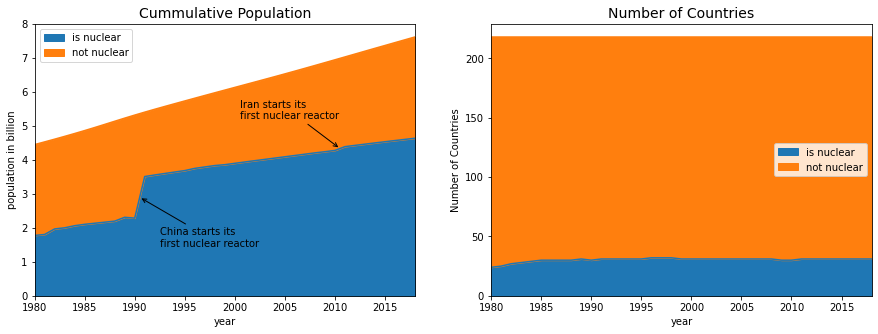

In [24]:
def plot_population_countries(data):
    data['population_in_billion'] = data['population']/1e9  # Convert to billion people
    data['BOOL'] = (data['operating_reactors']>0)
    df = pd.DataFrame()
    df['is nuclear'] = data['population_in_billion'][data['BOOL']].sum(level='year')
    df['not nuclear'] = data['population_in_billion'][~data['BOOL']].sum(level='year')

    %matplotlib inline
    fig, ax = plt.subplots(1,2, figsize=[15,5])
    
    df.plot(kind='area', ax=ax[0])
    ax[0].set_ylabel('population in billion')
    ax[0].set_xlim(df.index.min(),df.index.max())
    ax[0].set_title('Cummulative Population', fontsize=14)
    
    ycoord = 0.5 * (df.loc[1990,'is nuclear'] + df.loc[1991,'is nuclear'])
    ax[0].annotate(text = "China starts its \nfirst nuclear reactor",
                   xy=(1990.5,ycoord),
                   xytext=(1990.5+2,ycoord*0.5),
                   ha='left', arrowprops=dict(arrowstyle='->'))
    
    ycoord = 0.5 * (df.loc[2010,'is nuclear'] + df.loc[2011,'is nuclear'])
    ax[0].annotate(text = "Iran starts its \nfirst nuclear reactor",
                   xy=(2010.5,ycoord),
                   xytext=(2010.5-10,ycoord*1.2),
                   ha='left', arrowprops=dict(arrowstyle='->'))

    df = pd.DataFrame()
    df['is nuclear'] = data['BOOL'].sum(level='year')
    df['not nuclear'] = (~data['BOOL']).sum(level='year')
    
    df.plot(kind='area', ax=ax[1])
    ax[1].set_ylabel('Number of Countries')
    ax[1].set_xlim(df.index.min(),df.index.max())
    ax[1].set_title('Number of Countries', fontsize=14)
    return None

plot_population_countries(data)

### Are there correlations between the change of nuclear energy production and the change of other properties of a nation?

#### Compare data of two years (e.g. 1998 and 2018) and make scatterplots (for comparison of countries).

Compare relative change of following features with the relative change of nuclear energy production between two countries:

    population, GDP, GDP per capita, income per capita, research_%GDP, representative_government, fundamental_rights, checks_on_gouvernment, impartial_administration, civil_society_participation, nuclear_warheads
    
Although there can be seen no absolute tendencies, that are valid for most of the counties, the data of the different countries can be compared very well with the following function for plotting.

#### Usage of Plots:

`compare_years(data_cleaned,`**`feature(s) to plot, start year, end year`**`);`

By default, only the countries with nuclear reactors are shown (`nuclear_countries_only=True`). All countries are plotted, if this value is set to `False`, in case the data for the featue (y-axis) exists.

*To show the ISO3 code of the countires, click on a point (works as long as it is in 'interactive' mode). To hide ISO3 again, right-click on the text.*

In [6]:
def correlation_q3(data, start, end, nuclear_countries_only=True):
    # exclude countries, that do not use nuclear energy (in both year)
    if nuclear_countries_only:
        nuclear_countries = data.loc[[1998,2018],'operating_reactors'].sum(axis=0, level='country').replace(0,np.nan).dropna().index
        data = data.query("country in @nuclear_countries")
    df = data[['nuclear_prod_btu']+features]
    data_start = df.xs(start, level='year')
    data_end   = df.xs(end, level='year')
    data_quot  = (data_end.divide(data_start)-1).sort_index() # relative change
    
    # fill missing values with 0 and drop infinities
    data_quot = data_quot.fillna(0)
    data_quot = data_quot.replace(np.inf,np.nan).dropna()
    
    # transform data to interval [-1,1]
    #scaler = StandardScaler()
    #data_quot = pd.DataFrame(scaler.fit_transform(data_quot),
    #                        index=data_quot.index,
    #                        columns = data_quot.columns)
    
    # make plot
    %matplotlib inline
    plt.figure(figsize=[10,10])
    sns.heatmap(data_quot.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
    plt.title(f'Correlations of relative change between {start} and {end}' + 
              f'\n Number of Countries used: {data_quot.index.size}')
    plt.show()
    
    return data_quot

In [7]:
def compare_years(data, features, start, end, nuclear_countries_only=True):
    # exclude countries, that do not use nuclear energy (in both year)
    if nuclear_countries_only:
        nuclear_countries = data.loc[[1998,2018],'operating_reactors'].sum(axis=0, level='country').replace(0,np.nan).dropna().index
        data = data.query("country in @nuclear_countries")
    if type(features)!=list: features = [features]
    df = data[features+['nuclear_prod_btu']]
    data_start = df.xs(start, level='year')
    data_end   = df.xs(end, level='year')
    data_quot  = (data_end.divide(data_start)-1).sort_index() # relative change
    
    # fill missing values
    data_quot['nuclear_prod_btu']  = data_quot['nuclear_prod_btu'].fillna(0)
    data_quot  = data_quot.fillna(-np.inf)
    
    # get continent information (for colorcode of scatterplots)
    data_quot['Continent'] = cc.convert(data_quot.index.get_level_values('country').to_list(), src='ISO3', to='continent')
    
    # scale down countries with large change in nuclear production
    max_quot_nuc_prod = data_quot[data_quot['nuclear_prod_btu']>2]['nuclear_prod_btu'].to_dict()
    data_quot.loc[max_quot_nuc_prod.keys(),'nuclear_prod_btu'] = 2
    
    # make interactive plot
    %matplotlib notebook
    %matplotlib notebook
    for feature in features:
        fig, ax = plt.subplots(figsize=[10,7])
        sns.scatterplot(data=data_quot, 
                x='nuclear_prod_btu', y=feature,
                hue='Continent', legend='full', ax = ax,
                palette={'Asia':'C0','Europe':'C1','Africa':'C2','America':'C3','Oceania':'C4','Antarctica':'C5'}
        )
        ax.set_title(feature.upper() + f', relative change from {start} to {end}')
        ax.set_xlabel('Nuclear Production, Relative Change')

        # Show ISO code of country when clicking
        mplcursors.cursor(multiple = True).connect(
            "add", lambda sel: sel.annotation.set_text(
                  data_quot.index[sel.target.index]
        ))

        # Add arrows for countries with large change in nuclear production (that were scaled down)
        for ISO3 in max_quot_nuc_prod.keys():
            ax.annotate(text=f'{max_quot_nuc_prod[ISO3]:.1f}',
                       xy=(2,data_quot.loc[ISO3,feature]),
                       xytext=(2.2,data_quot.loc[ISO3,feature]),
                       ha='left', va='center', arrowprops=dict(arrowstyle='<-', color='C0'))

        # Move Axes to centre, passing through (0,0)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        ax.legend(loc='best')
    plt.show()
    
    return data_quot

Not sure why, but the cell below needs to be run twice.
<br> <span style="color:red">todo_frank fix possible?</span>

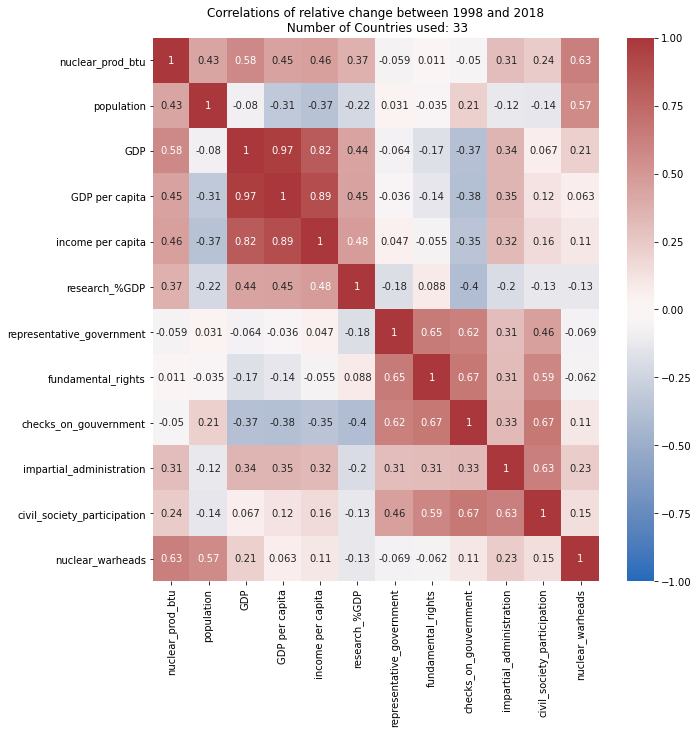

C:\Users\frank\anaconda3\envs\env1\lib\site-packages\country_converter\country_converter.py:578: FutureWarning: The default value of regex will change from True to False in a future version.
  _match_col = self.data[src_format].astype(str).str.replace("\\..*", "")


<IPython.core.display.Javascript object>


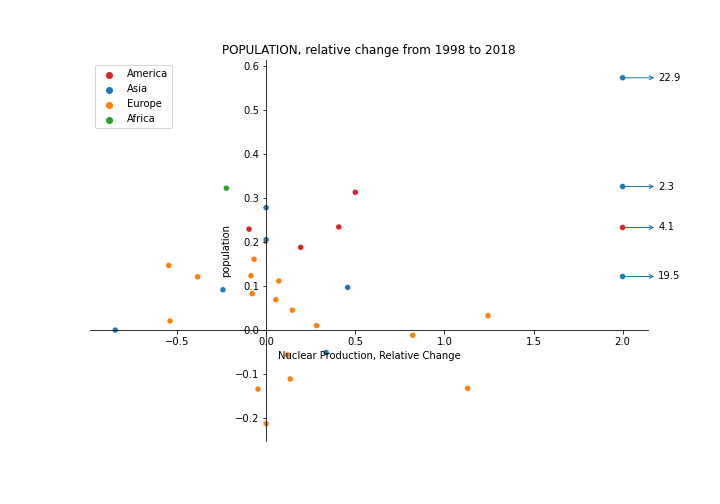

<IPython.core.display.Javascript object>


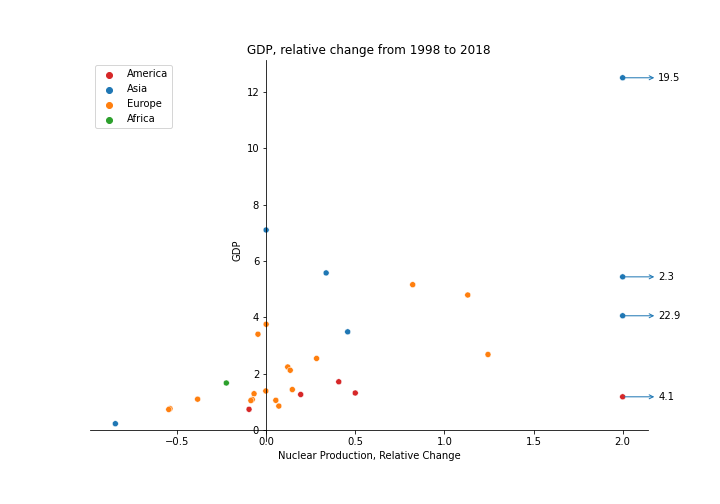

<IPython.core.display.Javascript object>


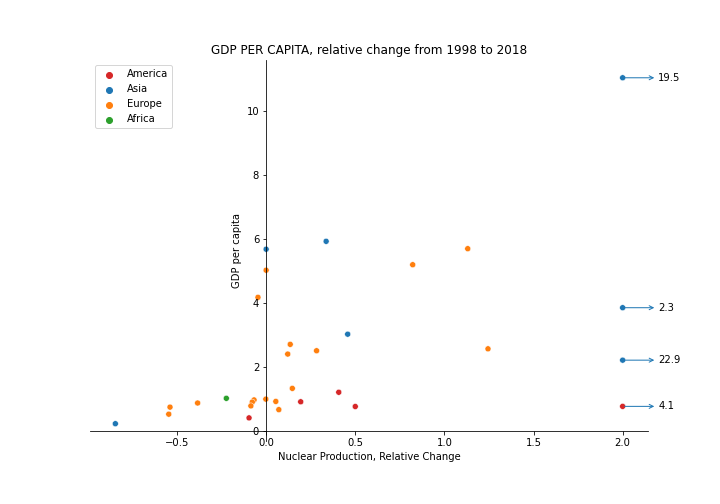

<IPython.core.display.Javascript object>


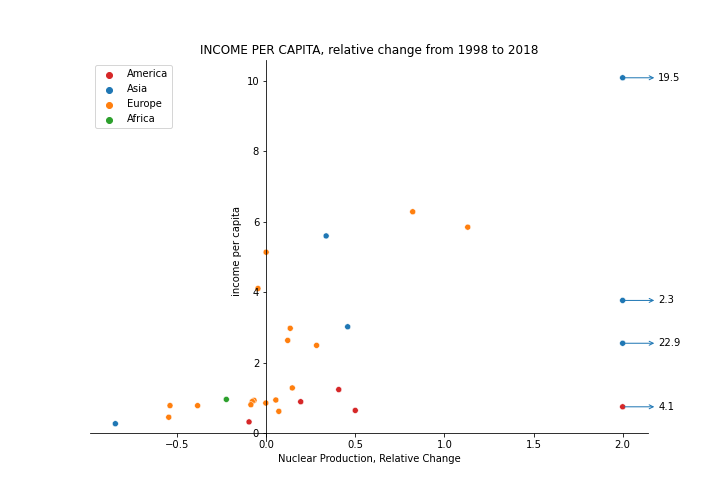

<IPython.core.display.Javascript object>


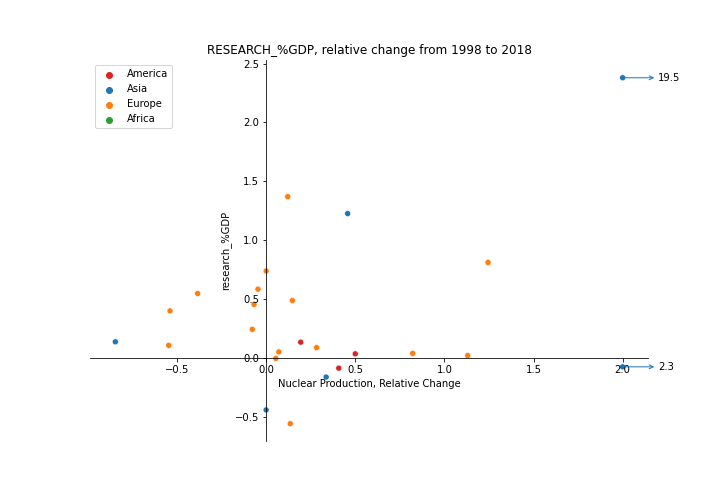

<IPython.core.display.Javascript object>


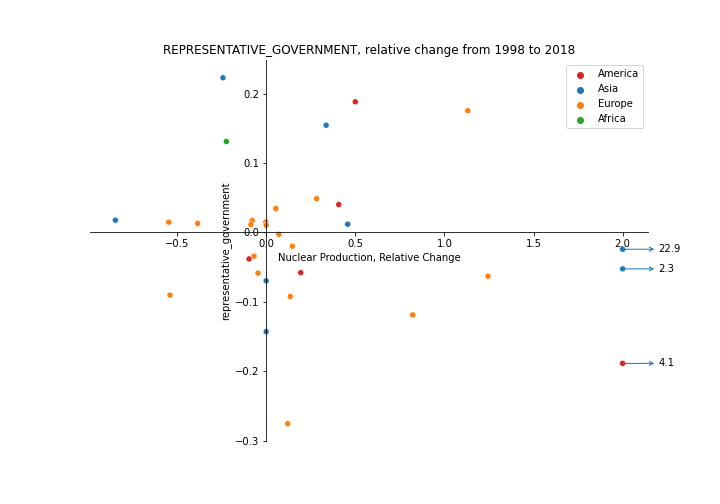

<IPython.core.display.Javascript object>


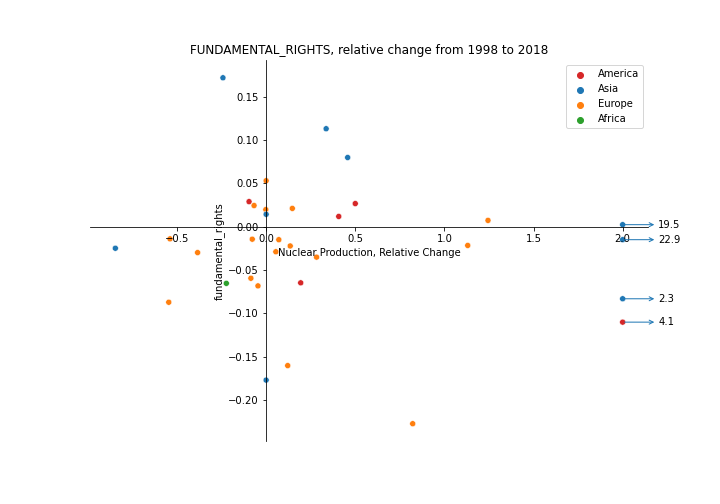

<IPython.core.display.Javascript object>


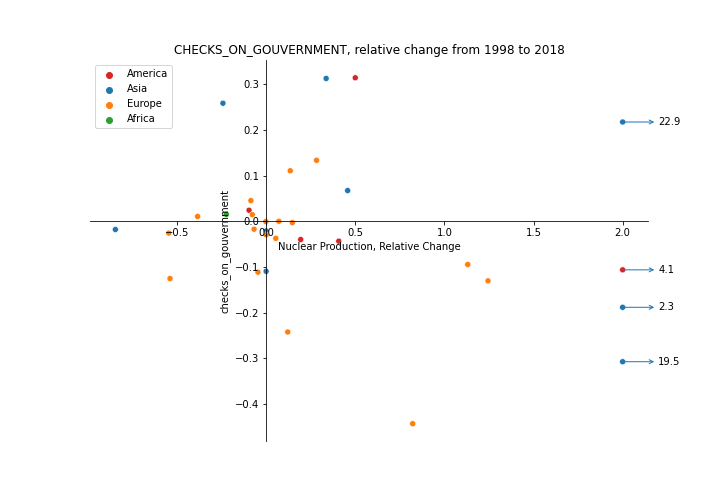

<IPython.core.display.Javascript object>


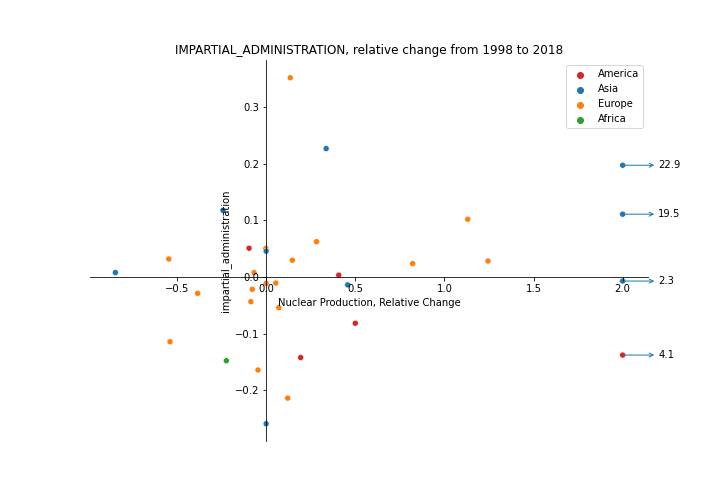

<IPython.core.display.Javascript object>


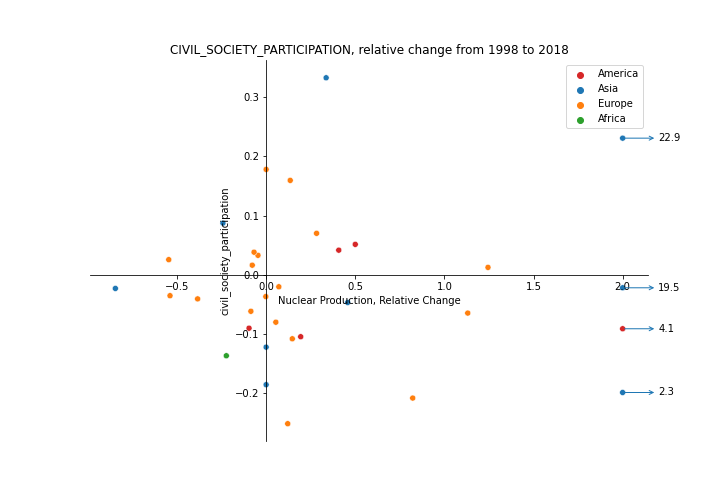

<IPython.core.display.Javascript object>


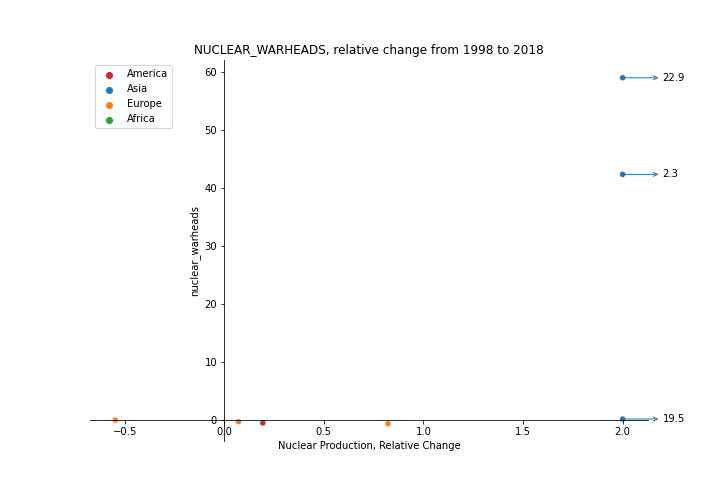

In [13]:
features = ['population','GDP','GDP per capita','income per capita','research_%GDP','representative_government','fundamental_rights',
                'checks_on_gouvernment','impartial_administration','civil_society_participation','nuclear_warheads']

start = 1998
end   = 2018
nuclear_countries_only=True

correlation_q3(data,          start, end, nuclear_countries_only);
compare_years(data, features, start, end, nuclear_countries_only);